# Enoncé

Vous avez participé à une compétition sur Kaggle sur le jeu de données de Titanic (celle-ci existe, les curieux peuvent la retrouver sur Kaggle !). Vous avez pour cela à votre disposition [une liste de 891 passagers](https://www.kaggle.com/c/titanic), contenant les caractéristiques suivantes :


- PassengerID : Identifiant du passager
- Survived : Indicateur de survi d'un passager (1 si le passager a survecu, 0 s’il est décédé)
- Pclass: Classe du passager (1 = 1ère classe, 2 = 2ème classe, 3 = 3ème classe)
- Name : Nom et titre du passager
- Sex : Sexe du passager
- Age : Age du passager (Décimal si inférieur à 1, estimé si de la forme xx.5)
- SibSp : Nombre d’époux, de frères et de soeurs présents à bord
- Parch : Nombre de parents ou d’enfants présents à bord 
- Ticket : Numéro du ticket 
- Fare : Tarif des tickets (Le prix est indiqué en £ et pour un seul achat (peut correspondre à plusieurs tickets)
- Cabin : Numéro de Cabine
- Embarked : Port d’embarcation (C = Cherbourg, Q = Queenstown, S = Southampton)
	 	

# Exercice

La compétition a été l’occasion de revenir sur ce jeu de données très célèbre, et plusieurs tâches étaient attendues, :
- identifier les facteurs favorisants la survie d'un passager par rapport à un autre, en dressant une typologie des survivants
- créer un algorithme qui pourrait prédire la survie d'un individu à partir de ces caractéristiques.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import statsmodels.formula.api as smf
import itertools
from random import randint, seed
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier #for using Decision Tree Algoithm
try:
    from sklearn.utils._testing import ignore_warnings
except ImportError:
    from sklearn.utils.testing import ignore_warnings
import warnings

from sklearn.exceptions import ConvergenceWarning
from datetime import datetime
from os import getcwd
from function import *
from mpl_toolkits.mplot3d import Axes3D
from joblib import dump, load

## 1. Charger vos données dans un DataFrame Pandas

In [2]:
# ---------------------------------------------------------------------------------------------
#                               MAIN
# ---------------------------------------------------------------------------------------------
verbose = False
verboseMain = False

print("Chargement des données...")
# Récupère le répertoire du programme
file_path = getcwd() + "\\"

Chargement des données...


In [3]:
file_name_test = 'titanic_dataset_kaggle_test_process_2022-01-15-18_44_17.csv'
file_name_train = 'titanic_dataset_kaggle_train_process_2022-01-15-18_44_17.csv'
file_name_test_y = 'titanic_dataset_kaggle_test_y.csv'

file_separator = ','

df_origin_train = pd.read_csv(file_path+file_name_train, sep=file_separator, index_col="PassengerId")
df_origin_test = pd.read_csv(file_path+file_name_test, sep=file_separator, index_col="PassengerId")
df_origin_test_y = pd.read_csv(file_path+file_name_test_y, sep=file_separator, index_col="PassengerId")

print("Chargement des données train:", df_origin_train.shape, ", test:", df_origin_test.shape, ".................................. END")

Chargement des données train: (891, 18) , test: (418, 17) .................................. END


In [26]:
-1 * -1

1

In [27]:
df_origin_test['Fare'] = df_origin_test['Fare'].fillna(0)
df_origin_train.loc[df_origin_train['Age']<0, 'Age'] = df_origin_train['Age'] * -1
df_origin_test.loc[df_origin_test['Age']<0, 'Age'] = df_origin_test['Age'] * -1
df_origin_train.head()

,Survived,Pclass,Name,Age,Sex,SibSp,Parch,group,Fare,Embarked,deck,Titre,Last_name,First_name,Sex_cod,Titre_cod,Embarked_cod,deck_cod
PassengerId,,,,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",22.0,male,1,0,1,7.2500,S,G,Mr,Braund,Owen Harris,1,7,2,6
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,female,1,0,1,71.2833,C,C,Mrs,Cumings,John Bradley (Florence Briggs Thayer),0,8,0,2
3,1,3,"Heikkinen, Miss. Laina",26.0,female,0,0,0,7.9250,S,G,Miss,Heikkinen,Laina,0,6,2,6
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,female,1,0,1,53.1000,S,C,Mrs,Futrelle,Jacques Heath (Lily May Peel),0,8,2,2
5,0,3,"Allen, Mr. William Henry",35.0,male,0,0,0,8.0500,S,B,Mr,Allen,William Henry,1,7,2,1


In [28]:
to_predict_columns = 'Survived'
columns = ['Pclass', 'Sex_cod', 'Titre_cod', 'Age', 'group', 'Fare', 'Embarked_cod', 'deck_cod'] 

X_train = df_origin_train[columns]
y_train = df_origin_train[to_predict_columns]

X_test = df_origin_test[columns]
y_test = df_origin_test_y[to_predict_columns]

# Features selection

## VarianceThreshold

In [6]:
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.2)
selector.fit(X_train)

VarianceThreshold(threshold=0.2)

In [7]:
selector.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True])

In [9]:
np.array(X_train.columns[selector.get_support()])

array(['Pclass', 'Sex_cod', 'Titre_cod', 'Age', 'group', 'Fare',
       'Embarked_cod', 'deck_cod'], dtype=object)

In [10]:
selector.variances_

array([6.98230591e-01, 2.28218083e-01, 9.41682696e-01, 1.85466439e+02,
       2.60032675e+00, 2.46666531e+03, 6.30094435e-01, 4.76205376e+00])

## 2. SelectKBest

In [11]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif

In [33]:
chi2(X_train, y_train)

(array([3.08736994e+01, 9.27024470e+01, 4.46504611e-01, 3.77681969e+01,
        7.09091328e-01, 4.51831909e+03, 9.75545583e+00, 5.65911377e+01]),
 array([2.75378563e-08, 6.07783826e-22, 5.03999550e-01, 7.96700736e-10,
        3.99745634e-01, 0.00000000e+00, 1.78791305e-03, 5.36531069e-14]))

In [47]:
selector = SelectKBest(f_classif, k=4)
selector.fit(X_train, y_train)
selector.scores_

array([1.15031272e+02, 3.72405724e+02, 3.22828006e+00, 6.10090323e+00,
       2.46193112e-01, 6.30307642e+01, 2.44228211e+01, 4.96559996e+01])

In [48]:
np.array(X_train.columns[selector.get_support()])

array(['Pclass', 'Sex_cod', 'Fare', 'deck_cod'], dtype=object)

## 3. Recursive feature Elimination

In [49]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import SGDClassifier

In [50]:
selector = RFECV(SGDClassifier(random_state=0), step=1, min_features_to_select=2, cv=5)
selector.fit(X_train, y_train)
print(selector.ranking_)
print(selector.grid_scores_)

[1 1 3 6 2 5 1 4]
[[0.80446927 0.80337079 0.38202247 0.75280899 0.80337079]
 [0.72625698 0.80337079 0.78651685 0.73033708 0.76966292]
 [0.7150838  0.66292135 0.7752809  0.69101124 0.74719101]
 [0.7150838  0.61797753 0.69662921 0.7247191  0.66853933]
 [0.7150838  0.74719101 0.41573034 0.71348315 0.74157303]
 [0.73184358 0.75280899 0.73033708 0.73033708 0.75280899]
 [0.42458101 0.74157303 0.76966292 0.78089888 0.61235955]]


C:\Program Files\Python39\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RFECV was fitted with feature names
  warnings.warn(
C:\Program Files\Python39\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


In [51]:
np.array(X_train.columns[selector.get_support()])

array(['Pclass', 'Sex_cod', 'Embarked_cod'], dtype=object)

## 4. SelectFromModel

In [52]:
from sklearn.feature_selection import SelectFromModel

In [53]:
selector = SelectFromModel(SGDClassifier(random_state=0), threshold='mean')
selector.fit(X_train, y_train)
selector.estimator_.coef_

array([[ -67.4324828 , -503.87990919,   88.78045475,   -7.15326488,
        -163.3289282 ,   17.29128122,  -21.00911525,  -19.99254515]])

In [54]:
np.array(X_train.columns[selector.get_support()])

array(['Sex_cod', 'group'], dtype=object)

# Machine Learning

La compétition a été l’occasion de revenir sur ce jeu de données très célèbre, et plusieurs tâches étaient attendues, :
- identifier les facteurs favorisants la survie d'un passager par rapport à un autre, en dressant une typologie des survivants
- créer un algorithme qui pourrait prédire la survie d'un individu à partir de ces caractéristiques.

Vous avez été ajouté à une équipe et le travail et lancé depuis quelques semaines : à cette étape,  la mission est en réalité finie (c.f. le présent notebook). Vos co-équipiers ont travaillé dur : il faut dans un premier temps vous approprier leur travail.

In [13]:
random_state = 0

In [14]:
df_origin_train.columns

Index(['Survived', 'Pclass', 'Name', 'Age', 'Sex', 'SibSp', 'Parch', 'group',
       'Fare', 'Embarked', 'deck', 'Titre', 'Last_name', 'First_name',
       'Sex_cod', 'Titre_cod', 'Embarked_cod', 'deck_cod'],
      dtype='object')

In [15]:
to_predict_columns = 'Survived'
columns = ['Pclass', 'Sex_cod', 'Titre_cod', 'Age', 'group', 'Fare', 'Embarked_cod', 'deck_cod'] 

X_train = df_origin_train[columns]
y_train = df_origin_train[to_predict_columns]

X_test = df_origin_test[columns]
y_test = df_origin_test_y[to_predict_columns]

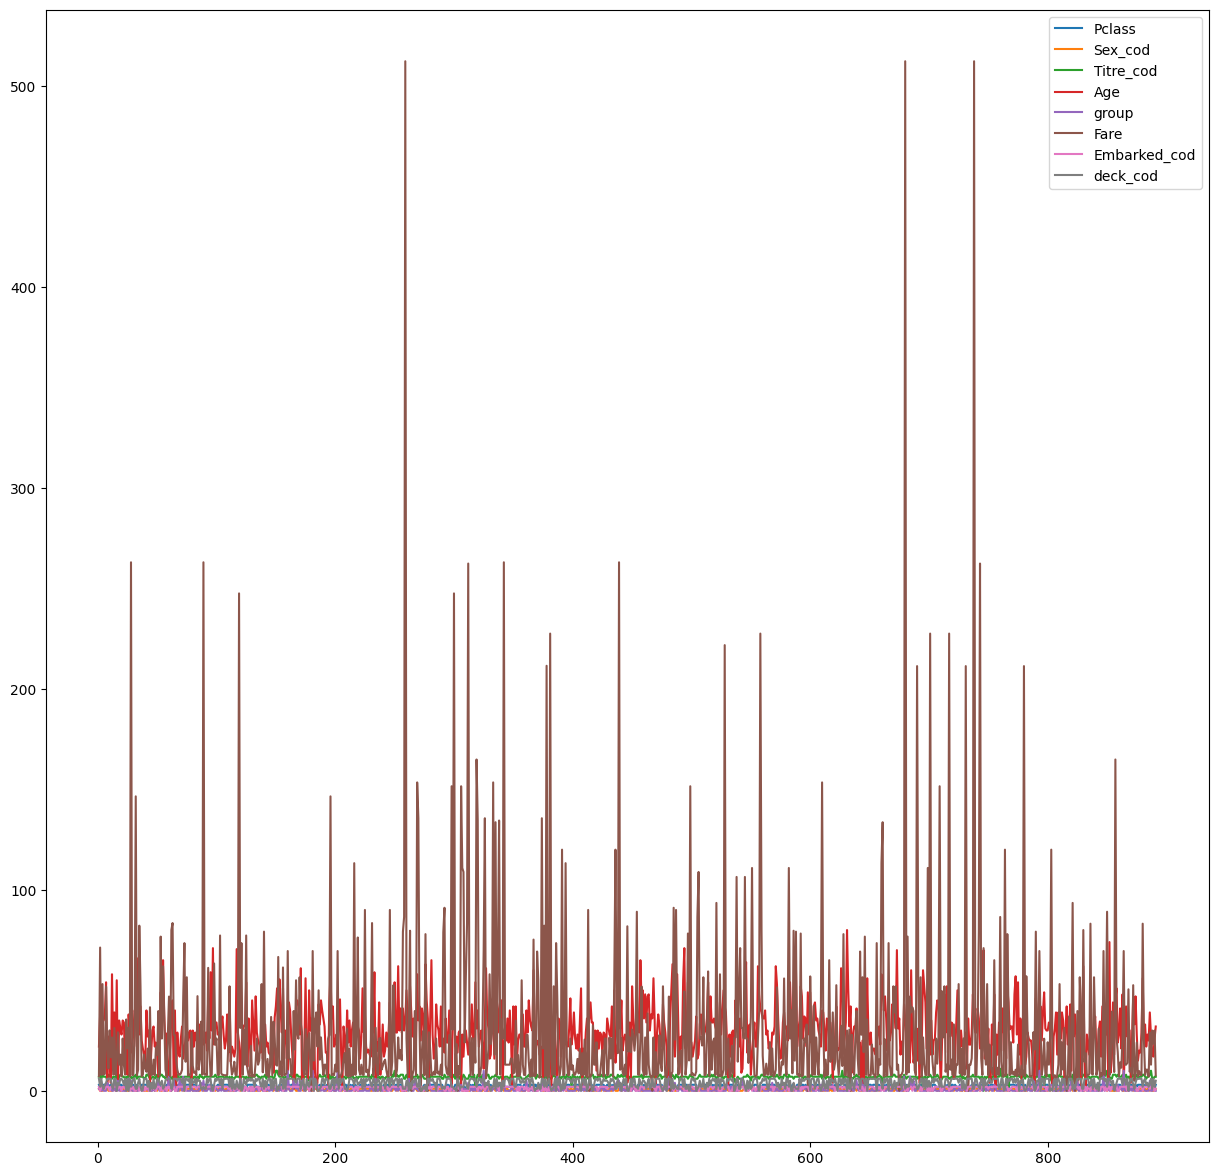

In [57]:
figure, ax = color_graph_background(1,1)
ax.plot(X_train)
ax.legend(X_train.columns)
figure.set_size_inches(15, 15, forward=True)
figure.set_dpi(100)

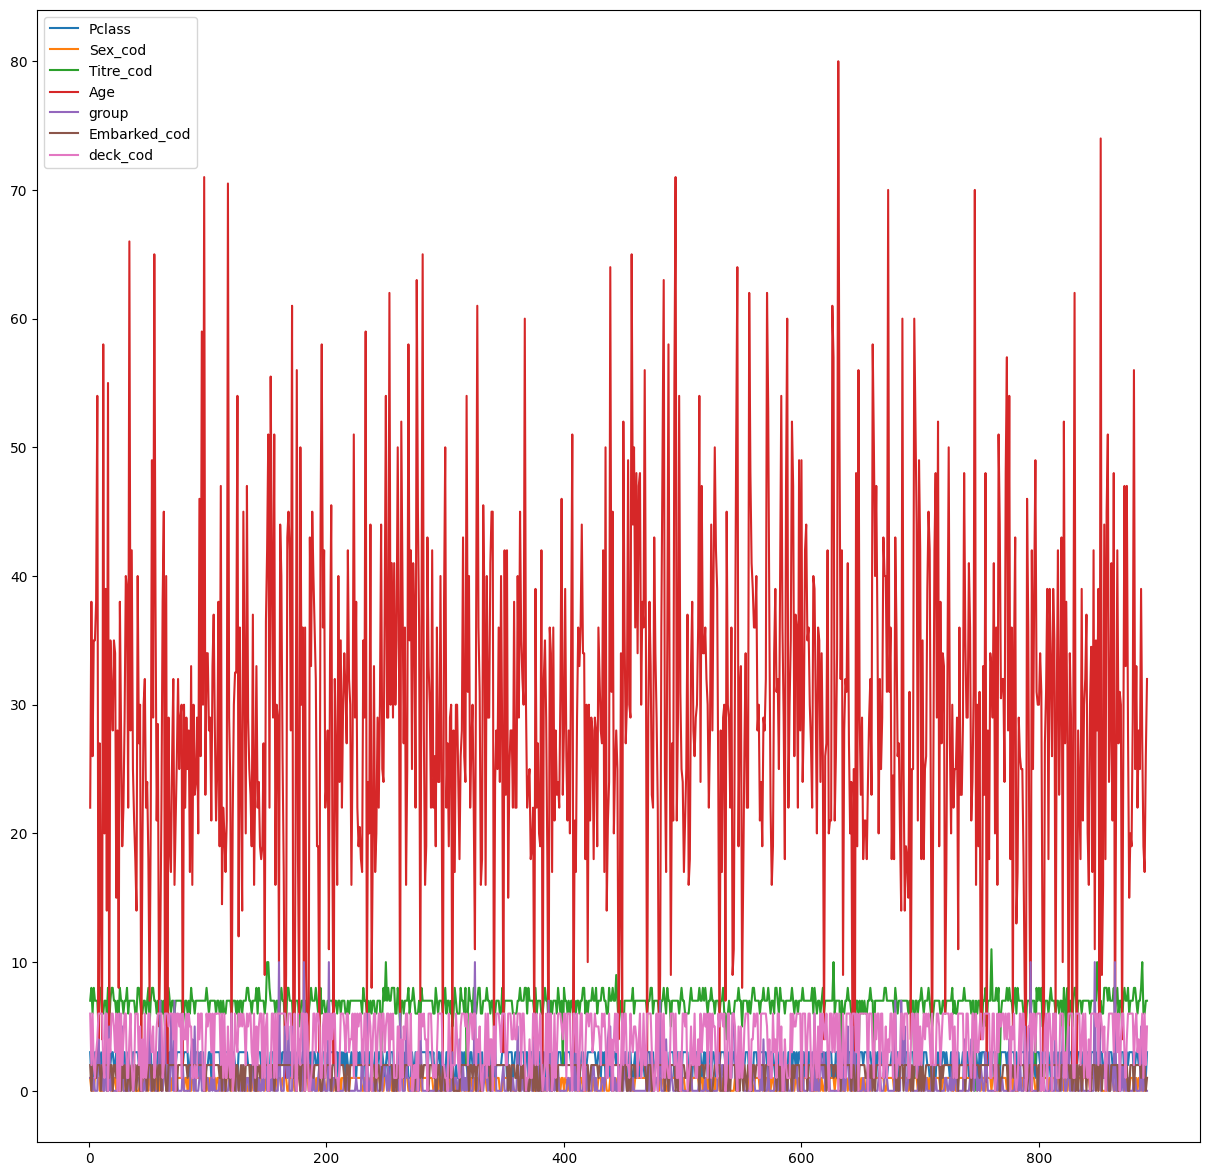

In [58]:
figure, ax = color_graph_background(1,1)
ax.plot(X_train[['Pclass', 'Sex_cod', 'Titre_cod', 'Age', 'group', 'Embarked_cod', 'deck_cod']])
ax.legend(['Pclass', 'Sex_cod', 'Titre_cod', 'Age', 'group', 'Embarked_cod', 'deck_cod'])
figure.set_size_inches(15, 15, forward=True)
figure.set_dpi(100)

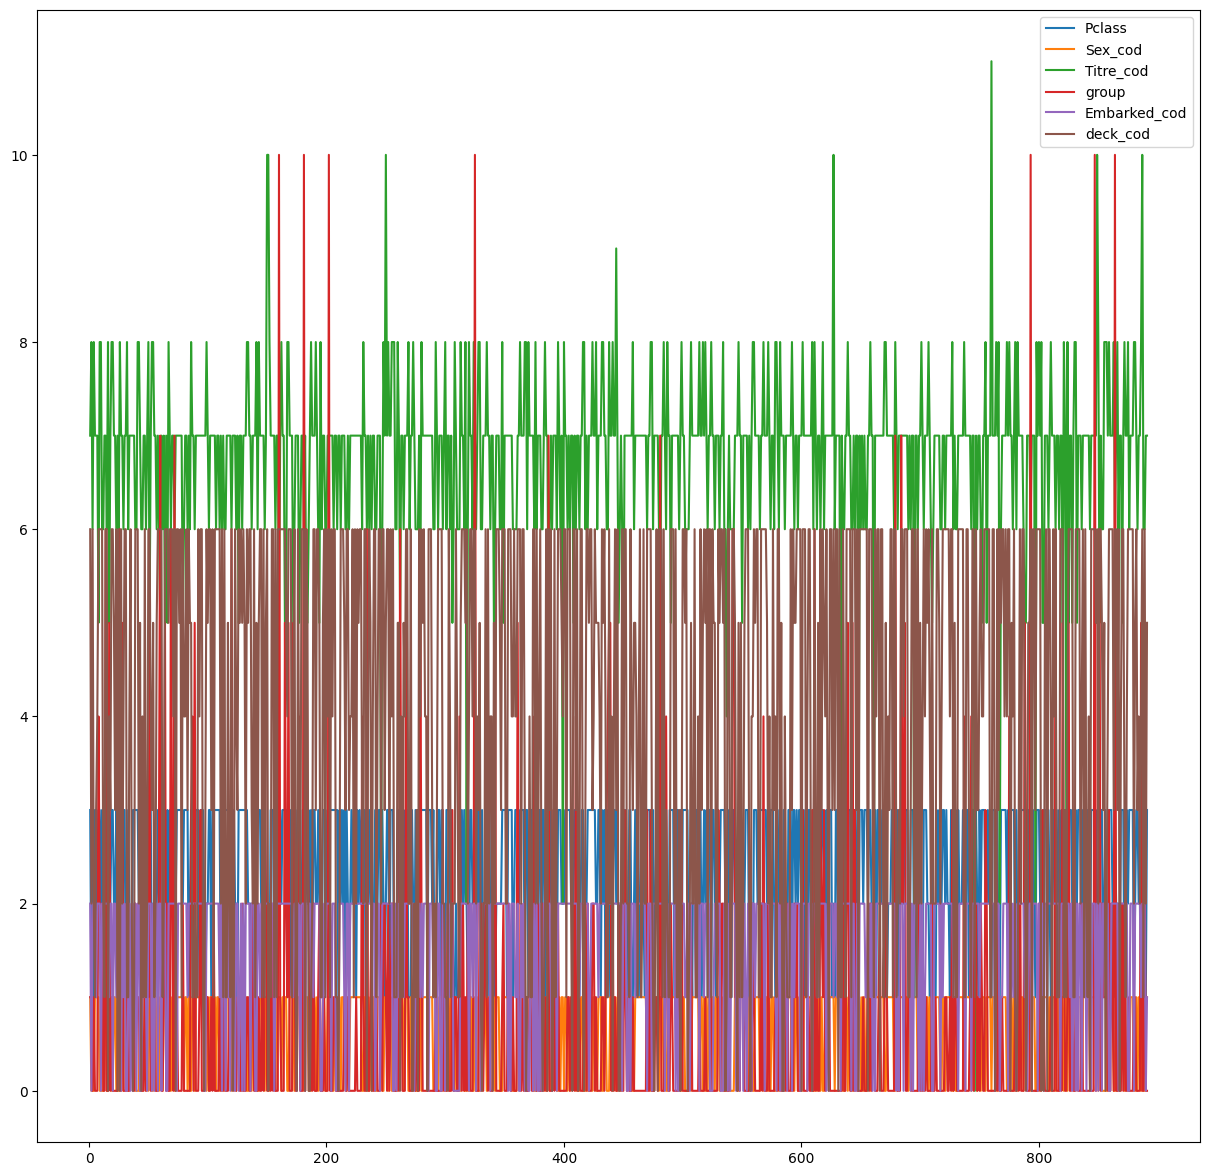

In [61]:
figure, ax = color_graph_background(1,1)
ax.plot(X_train[['Pclass', 'Sex_cod', 'Titre_cod', 'group', 'Embarked_cod', 'deck_cod']])
ax.legend(['Pclass', 'Sex_cod', 'Titre_cod', 'group', 'Embarked_cod', 'deck_cod'])
figure.set_size_inches(15, 15, forward=True)
figure.set_dpi(100)

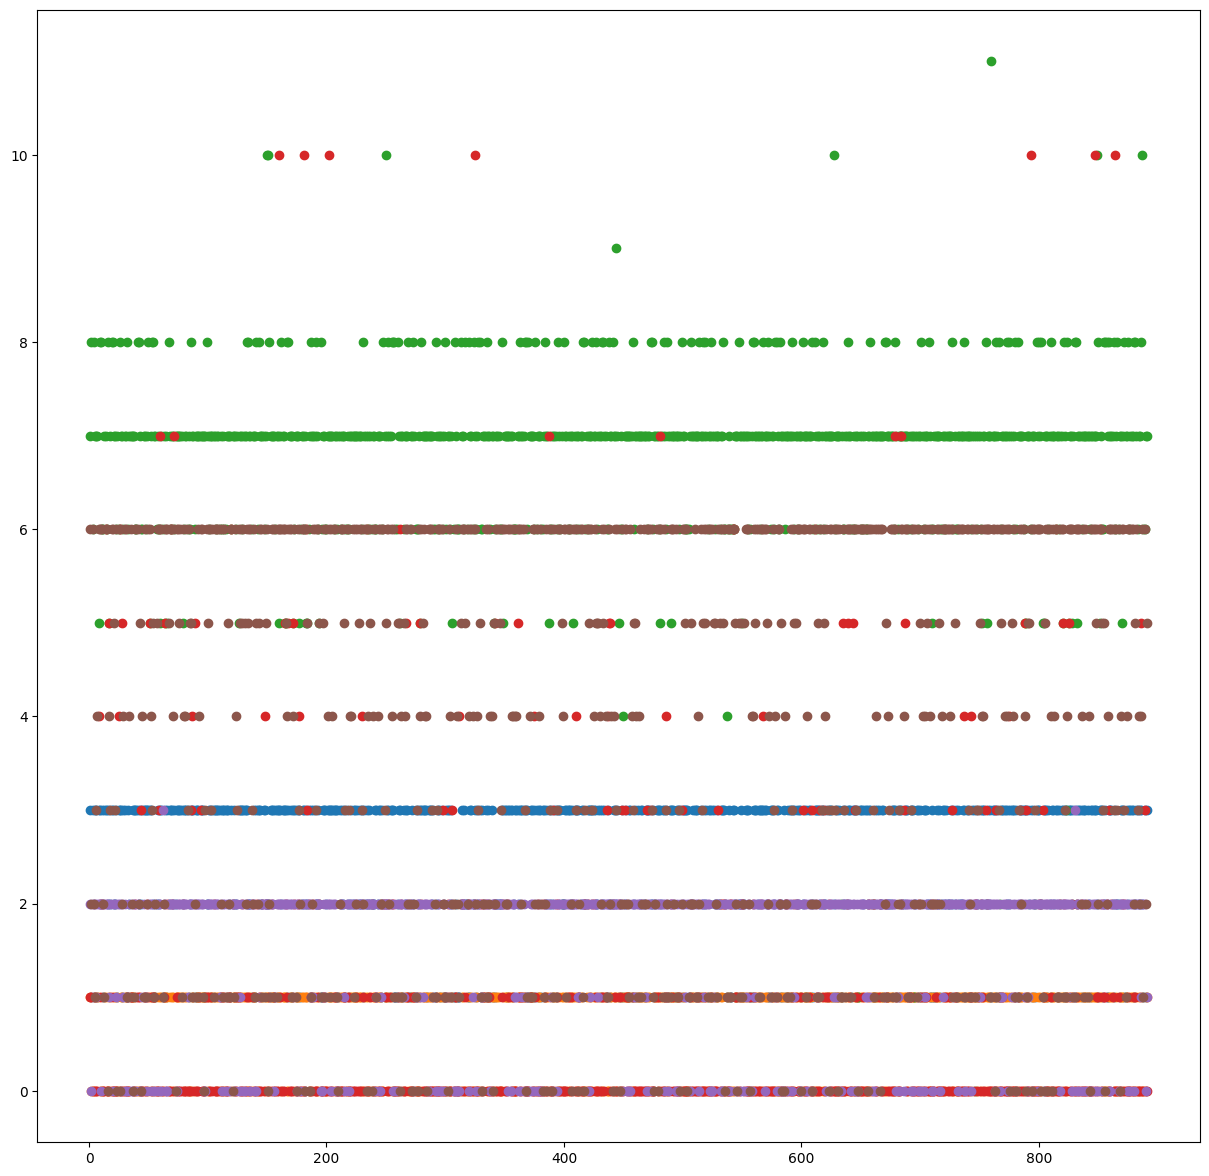

In [62]:
figure, ax = color_graph_background(1,1)
for col_name in ['Pclass', 'Sex_cod', 'Titre_cod', 'group', 'Embarked_cod', 'deck_cod']: 
    ax.scatter(X_train[col_name].index, X_train[col_name].values)
    # ax.legend(col_name)
    # ax.plot(X_train[['Pclass', 'Sex_cod', 'Titre_cod', 'group', 'Embarked_cod', 'deck_cod']])
    # ax.legend(['Pclass', 'Sex_cod', 'Titre_cod', 'group', 'Embarked_cod', 'deck_cod'])
figure.set_size_inches(15, 15, forward=True)
figure.set_dpi(100)

<mark>Manuellement j'avais les résultats suivants :</mark>
```python
1.0 for test ( 0.79 for train) => Logistic Regression, with: ['Pclass', 'Sex_cod', 'Titre_cod']
1.0 for test ( 0.79 for train) => K Nearest Neighbor, with: ['Pclass', 'Sex_cod']
1.0 for test ( 0.79 for train) => Decision Tree, with: ['Sex_cod']
1.0 for test ( 0.79 for train) => Random Forest, with: ['Pclass', 'Sex_cod']
1.0 for test ( 0.79 for train) => Support Vector Machine (Linear)
0.65 for test ( 0.69 for train) => Support Vector Machine (RBF)
0.81 for test ( 0.79 for train) => Gaussian Naive Bayes
```
Les paramétrages correspondants :
```python
LogisticReg : 
* fit_intercept= True or False
* penalty=none or l2 or l1
* solver=liblinear or newton-cg or lbfgs or sag or saga
* columns = ['Pclass', 'Sex_cod', 'Titre_cod']

KNN : 
* KNN = 2 :['Pclass', 'Sex_cod']
* KNN = 4 :['Embarked_cod', 'Pclass', 'Sex_cod']
* KNN = 1 :['Sex_cod']
* KNN = 1 :['Sex_cod', 'Titre_cod']
* KNN = 1 :['Embarked_cod', 'Sex_cod']
* KNN = 7 :['Sex_cod', 'deck_cod']

Decision Tree
* criterion = gini or entropy
* splitter=best or random
* columns = ['Sex_cod'] (0.98 de test <=> 0.81 de train, avec ['Pclass', 'Sex_cod', 'group'])

RandomForest :
* n_estimators= de 3 à 99 
* criterion=gini or entropy
* columns = ['Pclass', 'Sex_cod']
```

## 5.0 Transform

In [16]:
# Transformer
scaler = StandardScaler()
X_train_transform = scaler.fit_transform(X_train[['Embarked_cod', 'Pclass', 'Sex_cod']])
X_train_transform

array([[ 0.58111394,  0.82737724,  0.73769513],
       [-1.93846038, -1.56610693, -1.35557354],
       [ 0.58111394,  0.82737724, -1.35557354],
       ...,
       [ 0.58111394,  0.82737724, -1.35557354],
       [-1.93846038, -1.56610693,  0.73769513],
       [-0.67867322,  0.82737724,  0.73769513]])

In [17]:
grid_ex_params = {
            'polynomialfeatures__degree' : [2,3,4],
            'standardscaler__penality' : [None, 'l2', 'l1', 'elasticnet'],
            'KNeighborsClassifier__n_neighbors': [range(1,10)],
            'KNeighborsClassifier__p': [range(1,10)],# TODO compléter les valeurs
            'KNeighborsClassifier__metric' : ['minkowski'], # TODO compléter les valeurs
            'KNeighborsClassifier__weights' : ['uniform', 'distance'],
            'KNeighborsClassifier__algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'DecisionTreeClassifier__criterion' : ["gini", "entropy"],
            'DecisionTreeClassifier__splitter' : ["best", "random"],
            'RandomForestClassifier__criterion' : ["gini", "entropy"],
            'RandomForestClassifier__n_estimators' : [range(1,100,10)],
            'LogisticRegression__solver' : ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
            'LogisticRegression__penality' : [None, 'l2', 'l1', 'elasticnet'],
            'LogisticRegression__fit_intercept' :[True, False],
            'SVC__kernel': ['linear', 'rbf'] # TODO compléter les valeurs
}

In [18]:
grid_ex_params = {
            'polynomialfeatures__degree' : [2,3,4],
            'standardscaler__with_mean' : [True, False],
            'standardscaler__with_std' : [True, False]
}

In [19]:
grid_ex_pipeline = make_pipeline(PolynomialFeatures(), 
                           StandardScaler(), 
                           SGDClassifier(random_state=random_state))
grid_ex_pipeline

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier(random_state=0))])

In [20]:
grid_ex = GridSearchCV(grid_ex_pipeline,param_grid=grid_ex_params, cv=4)


In [21]:
grid_ex.fit(X_train, y_train)

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('standardscaler', StandardScaler()),
                                       ('sgdclassifier',
                                        SGDClassifier(random_state=0))]),
             param_grid={'polynomialfeatures__degree': [2, 3, 4],
                         'standardscaler__with_mean': [True, False],
                         'standardscaler__with_std': [True, False]})

In [22]:
grid_ex.best_params_

{'polynomialfeatures__degree': 3,
 'standardscaler__with_mean': False,
 'standardscaler__with_std': True}

In [23]:
grid_ex.score(X_test, y_test)

0.715311004784689

In [24]:
# Estimator
#model = KNeighborsClassifier(n_neighbors=4, weights="uniform", algorithm="auto", metric = 'minkowski', p = 2)
model = KNeighborsClassifier(n_neighbors=4, metric = 'minkowski', p = 2)
model.fit(X_train_transform, y_train)
X_test_transform = scaler.fit_transform(X_test[['Embarked_cod', 'Pclass', 'Sex_cod']])
score_test = model.score(X_test_transform,y_test)
score_test

0.84688995215311

## 5.1. GridSearchCV

In [25]:
random_state=0

In [26]:
grid_ex_params = {
            'polynomialfeatures__degree' : [2,3,4],
            'standardscaler__with_mean' : [True, False],
            'standardscaler__with_std' : [True, False]
}

In [27]:
grid_ex_pipeline = make_pipeline(PolynomialFeatures(), 
                           StandardScaler(), 
                           SGDClassifier(random_state=random_state))
grid_ex_pipeline

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier(random_state=0))])

In [28]:
grid_ex = GridSearchCV(grid_ex_pipeline,param_grid=grid_ex_params, cv=4)


In [29]:
grid_ex.fit(X_train, y_train)

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('standardscaler', StandardScaler()),
                                       ('sgdclassifier',
                                        SGDClassifier(random_state=0))]),
             param_grid={'polynomialfeatures__degree': [2, 3, 4],
                         'standardscaler__with_mean': [True, False],
                         'standardscaler__with_std': [True, False]})

In [30]:
grid_ex.best_params_

{'polynomialfeatures__degree': 3,
 'standardscaler__with_mean': False,
 'standardscaler__with_std': True}

In [31]:
grid_ex.score(X_test, y_test)

0.715311004784689

In [83]:
def get_models_grid(X_train, y_train, verbose=False):
    grid_dic = {}
    if verbose: print("randomforestclassifier", end="")
    grid_rf_params = { 'randomforestclassifier__criterion' : ["gini", "entropy"],
                   'randomforestclassifier__n_estimators' : np.arange(1, 100, 10)}
    grid_rf_pipeline = make_pipeline( RandomForestClassifier(random_state=random_state))
    grid_rf = GridSearchCV(grid_rf_pipeline,param_grid=grid_rf_params, cv=4)
    grid_rf.fit(X_train, y_train)
    grid_dic['randomforestclassifier'] = grid_rf
    if verbose: print(", kneighborsclassifier", end="")
    grid_knn_params = { 'kneighborsclassifier__n_neighbors': np.arange(1, 20),
                        'kneighborsclassifier__p': np.arange(1, 10),
                        'kneighborsclassifier__metric' : ['minkowski', 'euclidean', 'manhattan'],
                        'kneighborsclassifier__algorithm' : ['auto'],
                        'kneighborsclassifier__metric_params' : [None],
                        'kneighborsclassifier__n_jobs' : [None],
                        'kneighborsclassifier__weights' : ['uniform']
                        }
    grid_knn_pipeline = make_pipeline( KNeighborsClassifier())
    grid_knn = GridSearchCV(grid_knn_pipeline,param_grid=grid_knn_params, cv=4)
    grid_knn.fit(X_train, y_train)
    grid_dic['kneighborsclassifier'] = grid_knn
    if verbose: print(", decisiontreeclassifier", end="")
    grid_dtc_params = { 'decisiontreeclassifier__criterion' : ["gini", "entropy"],
                    'decisiontreeclassifier__splitter' : ["best", "random"]}
    grid_dtc_pipeline = make_pipeline( DecisionTreeClassifier(random_state=random_state))
    grid_dtc = GridSearchCV(grid_dtc_pipeline,param_grid=grid_dtc_params, cv=4)
    grid_dtc.fit(X_train, y_train)
    grid_dic['decisiontreeclassifier'] = grid_dtc
    if verbose: print(", logisticregression", end="")
    grid_lr_params = { 'logisticregression__solver' : ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
                    'logisticregression__penalty' : [None, 'l2', 'l1', 'elasticnet'],
                    'logisticregression__fit_intercept' : [True, False]}
    # penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None
    grid_lr_pipeline = make_pipeline( LogisticRegression(random_state=random_state))
    grid_lr = GridSearchCV(grid_lr_pipeline,param_grid=grid_lr_params, cv=4)
    grid_lr.fit(X_train, y_train)
    grid_dic['logisticregression'] = grid_lr
    if verbose: print("                 DONE")
    return grid_dic

In [80]:
grid_dic = get_models_grid(X_train, y_train)

In [84]:
warnings.filterwarnings("ignore")
@ignore_warnings(category=ConvergenceWarning)
def found_better_config_by_model(X_train, X_test, y_train, y_test, verbose=False):

    # on prend un maximum de colonne pour commencer
    columns_started = list(X_train.columns)
    better_grid_score_dic = {}
    better_grid_equals = {}
    ever_test = []
    
    # Modifier l'ordre des colonnes pour trouver encore d'autres configurations pertinentes
    # Positionnement de 6 suite aux tests lancés et des premiers résultats
    for subset in itertools.permutations(columns_started, 6):
        columns = list(subset)
            
        # a chaque tour, on regardera le meilleur score
        while len(columns)>0:
            str_col = str(sorted(columns))
            if str_col not in ever_test:
                grid_dic = get_models_grid(X_train[columns], y_train)
                for model_name,grid in grid_dic.items():
                    score = grid.score(X_test[columns], y_test)

                    model_better_score = better_grid_score_dic.get(model_name, 0)
                    model_grig_res = (grid, score, str_col)
                    if score > model_better_score:
                        model_better_score = score
                        better_grid_equals[model_name] = [model_grig_res]
                        if verbose:
                            print(f"{model_name} New Best :{round(score,2)} de test, {str_col}, {grid.best_params_}")
                    elif score == model_better_score:
                        better_grid_equals[model_name].append(model_grig_res)
                        if verbose:
                            print(f"{model_name} Same Best :{round(score,2)} de test, {str_col}, {grid.best_params_}")

                    better_grid_score_dic[model_name] = model_better_score
                ever_test.append(str_col)
                if verbose>1: print(str_col, "         DONE")
            # On supprime une colonne
            columns.pop()
    
    return better_grid_score_dic, better_grid_equals

In [85]:
better_grid_score_dic, better_grid_equals = found_better_config_by_model(X_train, X_test, y_train, y_test, verbose=True)

randomforestclassifier New Best :0.5 de test, ['Age', 'Fare', 'Pclass', 'Sex_cod', 'Titre_cod', 'group'], {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__n_estimators': 81}
kneighborsclassifier New Best :0.68 de test, ['Age', 'Fare', 'Pclass', 'Sex_cod', 'Titre_cod', 'group'], {'kneighborsclassifier__algorithm': 'auto', 'kneighborsclassifier__metric': 'minkowski', 'kneighborsclassifier__metric_params': None, 'kneighborsclassifier__n_jobs': None, 'kneighborsclassifier__n_neighbors': 19, 'kneighborsclassifier__p': 1, 'kneighborsclassifier__weights': 'uniform'}
decisiontreeclassifier New Best :0.82 de test, ['Age', 'Fare', 'Pclass', 'Sex_cod', 'Titre_cod', 'group'], {'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__splitter': 'best'}
logisticregression New Best :0.94 de test, ['Age', 'Fare', 'Pclass', 'Sex_cod', 'Titre_cod', 'group'], {'logisticregression__fit_intercept': True, 'logisticregression__penalty': 'l2', 'logisticregression__solver'

In [ ]:
better_grid_score_dic

{'randomforestclassifier': 1.0,
 'kneighborsclassifier': 1.0,
 'decisiontreeclassifier': 1.0,
 'logisticregression': 1.0}

In [ ]:
better_models = {}
# Affichage des meilleures configurations et colonnes
for k in better_grid_equals.keys():
    v = better_grid_equals[k]
    str_cols = ""
    params = None
    print(k)
    for val in v:
        if val[-1].count(',')> str_cols.count(','):
            str_cols = val[-1]
            params = val[0]
        print(val[-1], end="")
        if isinstance(val[0], GridSearchCV):
            print(val[0].best_params_, end="")
        print("")
    better_models[k] = params,str_cols

randomforestclassifier
['Sex_cod']{'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__n_estimators': 1}
['Sex_cod', 'Titre_cod']{'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__n_estimators': 1}
['Embarked_cod', 'Sex_cod']{'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__n_estimators': 11}
['Sex_cod', 'deck_cod']{'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__n_estimators': 11}
kneighborsclassifier
['Pclass', 'Sex_cod']{'kneighborsclassifier__metric': 'minkowski', 'kneighborsclassifier__n_neighbors': 4, 'kneighborsclassifier__p': 1}
['Sex_cod']{'kneighborsclassifier__metric': 'minkowski', 'kneighborsclassifier__n_neighbors': 9, 'kneighborsclassifier__p': 1}
['Embarked_cod', 'Sex_cod']{'kneighborsclassifier__metric': 'minkowski', 'kneighborsclassifier__n_neighbors': 5, 'kneighborsclassifier__p': 1}
decisiontreeclassifier
['Sex_cod']{'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__s

<mark>Avec Grid Search CV j'ai les résultats :</mark>

```Python
randomforestclassifier = 1.0
kneighborsclassifier = 1.0
decisiontreeclassifier = 1.0
logisticregression = 1.0
```
Avec les paramètres :

```Python
# logisticregression
['Pclass', 'Sex_cod', 'Titre_cod'],              {'fit_intercept': True, 'penalty': 'l2', 'solver': 'liblinear'}
['Pclass', 'Sex_cod'],                           {'fit_intercept': True, 'penalty': 'l2', 'solver': 'newton-cg'}
['Pclass', 'Sex_cod', 'deck_cod'],               {'fit_intercept': False, 'penalty': 'l2', 'solver': 'newton-cg'}
['Sex_cod'],                                     {'fit_intercept': True, 'penalty': 'l2', 'solver': 'newton-cg'}
['Sex_cod', 'Titre_cod'],                        {'fit_intercept': True, 'penalty': 'l2', 'solver': 'newton-cg'}
['Age', 'Sex_cod', 'Titre_cod'],                 {'fit_intercept': True, 'penalty': 'l2', 'solver': 'liblinear'}
['Age', 'Embarked_cod', 'Sex_cod', 'Titre_cod'], {'fit_intercept': True, 'penalty': 'l2', 'solver': 'liblinear'}
['Age', 'Sex_cod', 'Titre_cod', 'deck_cod'],     {'fit_intercept': True, 'penalty': 'l2', 'solver': 'liblinear'}
['Embarked_cod', 'Sex_cod', 'Titre_cod'],        {'fit_intercept': True, 'penalty': 'l2', 'solver': 'liblinear'}
['Sex_cod', 'Titre_cod', 'deck_cod'],            {'fit_intercept': True, 'penalty': 'l2', 'solver': 'liblinear'}
['Age', 'Sex_cod'],                              {'fit_intercept': True, 'penalty': 'l2', 'solver': 'newton-cg'}
['Age', 'Sex_cod', 'deck_cod'],                  {'fit_intercept': True, 'penalty': 'l2', 'solver': 'sag'}
['Embarked_cod', 'Sex_cod'],                     {'fit_intercept': True, 'penalty': 'l2', 'solver': 'newton-cg'}
['Embarked_cod', 'Sex_cod', 'deck_cod'],         {'fit_intercept': True, 'penalty': 'l2', 'solver': 'liblinear'}
['Sex_cod', 'deck_cod'],                         {'fit_intercept': True, 'penalty': 'l2', 'solver': 'newton-cg'}

# randomforestclassifier :
['Sex_cod'],                 {'criterion': 'gini', 'n_estimators': 1}
['Sex_cod', 'Titre_cod'],    {'criterion': 'gini', 'n_estimators': 1}
['Embarked_cod', 'Sex_cod'], {'criterion': 'gini', 'n_estimators': 11}
['Sex_cod', 'deck_cod'],     {'criterion': 'gini', 'n_estimators': 11}

# kneighborsclassifier:
['Pclass', 'Sex_cod'],       {'metric': 'minkowski', 'n_neighbors': 4, 'p': 1}
['Sex_cod'],                 {'metric': 'minkowski', 'n_neighbors': 9, 'p': 1}
['Embarked_cod', 'Sex_cod'], {'metric': 'minkowski', 'n_neighbors': 5, 'p': 1}

# decisiontreeclassifier:
['Sex_cod'],                 {'criterion': 'gini', 'splitter': 'best'}
['Embarked_cod', 'Sex_cod'], {'criterion': 'gini', 'splitter': 'best'}
['Sex_cod', 'deck_cod'],     {'criterion': 'gini', 'splitter': 'best'}
```


## 5.1 PREDICTIONS

In [70]:
X_train.columns

Index(['Pclass', 'Sex_cod', 'Titre_cod', 'Age', 'group', 'Fare',
       'Embarked_cod', 'deck_cod'],
      dtype='object')

# TODO Question :

Est-ce que l'encodage des valeurs pour train est la même pour test alors que ces dataset n'ont pas les mêmes valeurs, donc le 2 de train est peut-être le 1 de test

In [60]:
titres_dic = {"Mr" : 7, "Miss" : 6, "Mrs" : 8, "Master" : 5, "Dr" : 2, "Rev" : 6}
col = ['Pclass', 'sex_cod', 'title_cod', 'embarked_cod', 'deck_cod']

In [74]:
seed(a=8, version=2)

In [77]:
passengers_dic = [ {'Pclass':3, 'Sex_cod':1, 'Age':randint(0, 80), 'title_cod':titres_dic["Miss"], 'Embarked_cod' : randint(0, 3), 'deck_cod': randint(-1, 6)},
             {'Pclass':2, 'Sex_cod':1, 'Age':randint(0, 80), 'title_cod':titres_dic["Miss"], 'Embarked_cod' : randint(0, 3), 'deck_cod': randint(-1, 6)},
             {'Pclass':1, 'Sex_cod':1, 'Age':randint(0, 80), 'title_cod':titres_dic["Miss"], 'Embarked_cod' : randint(0, 3), 'deck_cod': randint(-1, 6)},
             {'Pclass':1, 'Sex_cod':1, 'Age':randint(15, 80), 'title_cod':titres_dic["Mrs"], 'Embarked_cod' : randint(0, 3), 'deck_cod': randint(-1, 6)},
             {'Pclass':2, 'Sex_cod':1, 'Age':randint(15, 80), 'title_cod':titres_dic["Mrs"], 'Embarked_cod' : randint(0, 3), 'deck_cod': randint(-1, 6)},
             {'Pclass':3, 'Sex_cod':1, 'Age':randint(15, 80), 'title_cod':titres_dic["Mrs"], 'Embarked_cod' : randint(0, 3), 'deck_cod': randint(-1, 6)},
             {'Pclass':3, 'Sex_cod':0, 'Age':randint(0, 80), 'title_cod':titres_dic["Mr"], 'Embarked_cod' : randint(0, 3), 'deck_cod': randint(-1, 6)},
             {'Pclass':2, 'Sex_cod':0, 'Age':randint(0, 80), 'title_cod':titres_dic["Mr"], 'Embarked_cod' : randint(0, 3), 'deck_cod': randint(-1, 6)},
             {'Pclass':1, 'Sex_cod':0, 'Age':randint(0, 80), 'title_cod':titres_dic["Mr"], 'Embarked_cod' : randint(0, 3), 'deck_cod': randint(-1, 6)},
             {'Pclass':1, 'Sex_cod':0, 'Age':randint(20, 80), 'title_cod':titres_dic["Master"], 'Embarked_cod' : randint(0, 3), 'deck_cod': randint(-1, 6)},
             {'Pclass':2, 'Sex_cod':0, 'Age':randint(20, 80), 'title_cod':titres_dic["Master"], 'Embarked_cod' : randint(0, 3), 'deck_cod': randint(-1, 6)},
             {'Pclass':3, 'Sex_cod':0, 'Age':randint(20, 80), 'title_cod':titres_dic["Master"], 'Embarked_cod' : randint(0, 3), 'deck_cod': randint(-1, 6)}
]

In [78]:
for passenger in passengers_dic:
    print('Pclass:', passenger['Pclass'], ", Sex_cod:", passenger['Sex_cod'], ', Age:',passenger['Age'], ', title_cod:', passenger['title_cod'], ', Embarked_cod:', passenger['Embarked_cod'], ', deck_cod:', passenger['deck_cod'] )

Pclass: 3 , Sex_cod: 1 , Age: 29 , title_cod: 6 , Embarked_cod: 2 , deck_cod: 5
Pclass: 2 , Sex_cod: 1 , Age: 16 , title_cod: 6 , Embarked_cod: 1 , deck_cod: -1
Pclass: 1 , Sex_cod: 1 , Age: 10 , title_cod: 6 , Embarked_cod: 1 , deck_cod: 2
Pclass: 1 , Sex_cod: 1 , Age: 79 , title_cod: 8 , Embarked_cod: 1 , deck_cod: 5
Pclass: 2 , Sex_cod: 1 , Age: 18 , title_cod: 8 , Embarked_cod: 3 , deck_cod: 6
Pclass: 3 , Sex_cod: 1 , Age: 73 , title_cod: 8 , Embarked_cod: 3 , deck_cod: 6
Pclass: 3 , Sex_cod: 0 , Age: 73 , title_cod: 7 , Embarked_cod: 1 , deck_cod: 5
Pclass: 2 , Sex_cod: 0 , Age: 11 , title_cod: 7 , Embarked_cod: 3 , deck_cod: 2
Pclass: 1 , Sex_cod: 0 , Age: 2 , title_cod: 7 , Embarked_cod: 2 , deck_cod: 5
Pclass: 1 , Sex_cod: 0 , Age: 50 , title_cod: 5 , Embarked_cod: 3 , deck_cod: 0
Pclass: 2 , Sex_cod: 0 , Age: 62 , title_cod: 5 , Embarked_cod: 2 , deck_cod: 0
Pclass: 3 , Sex_cod: 0 , Age: 72 , title_cod: 5 , Embarked_cod: 0 , deck_cod: 5


### KNN

In [ ]:
better_knn_model = better_models['kneighborsclassifier'][0]
better_knn_columns = better_models['kneighborsclassifier'][1]
print(better_knn_columns, better_knn_model)

['Pclass', 'Sex_cod'] GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__metric': ['minkowski'],
                         'kneighborsclassifier__n_neighbors': [1, 2, 3, 4, 5, 6,
                                                               7, 8, 9],
                         'kneighborsclassifier__p': [1, 2, 3, 4, 5, 6, 7, 8,
                                                     9]})


In [ ]:
@ignore_warnings(category=UserWarning)
def knn_predire_survie(model, pclass=3, sex=1, age=40, title=6, deck = randint(0, 6), embarked_cod = randint(-1, 2)):
    ['Pclass', 'Sex_cod']
    deck = randint(0, 6)
    embarked_cod = randint(-1, 2)
    # ['Pclass', 'sex_cod', 'title_cod', 'embarked_cod', 'deck_cod']
    params = [pclass, sex, title, embarked_cod, deck]
    return predire_survie(model, params)

In [ ]:
better_tree_model = better_models['decisiontreeclassifier'][0]
better_tree_columns = better_models['decisiontreeclassifier'][1]
print(better_tree_columns, better_tree_model)

['Embarked_cod', 'Sex_cod'] GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('decisiontreeclassifier',
                                        DecisionTreeClassifier(random_state=0))]),
             param_grid={'decisiontreeclassifier__criterion': ['gini',
                                                               'entropy'],
                         'decisiontreeclassifier__splitter': ['best',
                                                              'random']})


In [56]:
better_forest_model = better_models['randomforestclassifier'][0]
better_forest_columns = better_models['randomforestclassifier'][1]
print(better_forest_columns, better_forest_model)

['Sex_cod', 'Titre_cod'] GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('randomforestclassifier',
                                        RandomForestClassifier(random_state=0))]),
             param_grid={'randomforestclassifier__criterion': ['gini',
                                                               'entropy'],
                         'randomforestclassifier__n_estimators': [1, 11, 21, 31,
                                                                  41, 51, 61,
                                                                  71, 81, 91]})


In [57]:
better_logistic_model = better_models['logisticregression'][0]
better_logistic_columns = better_models['logisticregression'][1]
print(better_logistic_columns, better_logistic_model)

['Age', 'Embarked_cod', 'Sex_cod', 'Titre_cod'] GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('logisticregression',
                                        LogisticRegression(random_state=0))]),
             param_grid={'logisticregression__fit_intercept': [True, False],
                         'logisticregression__penalty': [None, 'l2', 'l1',
                                                         'elasticnet'],
                         'logisticregression__solver': ['newton-cg', 'lbfgs',
                                                        'liblinear', 'sag',
                                                        'saga']})


## 5.3. RandomForestClassifier

* RandomForestClassifier
j'ai essayé le random forest sur ton fichier, j'ai eu un score de 0,85  et en ajoutant une colonne titre comme 'Countess,Major ...' j'arrive à avoir un score de 0,86
oui, avec les variables catégorielles comme le deck par exemple tu peux utiliser le from sklearn.preprocessing import OrdinalEncoder pour qu'elle soit exploitable par l'algorithme de machine learning
* KNeighborsClassifier

In [177]:
from sklearn.ensemble import RandomForestClassifier 

columns_logistic = ['Pclass', 'sex_cod', 'title_cod', 'embarked_cod', 'deck_cod']

model_forest = RandomForestClassifier(n_estimators=100,random_state=random_state)
model_forest.fit(X_train[columns_logistic],y_train)
pd.Series(model_forest.feature_importances_,index=columns_logistic).sort_values(ascending=False)

sex_cod         0.317152
deck_cod        0.226847
title_cod       0.206376
Pclass          0.159743
embarked_cod    0.089883
dtype: float64

In [178]:
model_forest.score(X_test[columns_logistic], y_test)

0.8770949720670391

## 5.4. Decision tree

In [179]:
columns_decision_tree_started = ['Pclass', 'sex_cod', 'title_cod', 'Age', 'family_on_board', 'Fare', 'embarked_cod', 'deck_cod']

model_decision_tree=DecisionTreeClassifier()
model_decision_tree.fit(X_train[columns_decision_tree_started],y_train)
print(model_decision_tree.score(X_test[columns_decision_tree_started], y_test))
prediction=model_decision_tree.predict(X_test[columns_decision_tree_started])
# print('The accuracy of the Decision Tree is',metrics.accuracy_score(prediction,test_y))

0.7988826815642458
